# Classifying Surnames with a Multilayer Perceptron

## Imports

In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import notebook

## Data Vectorization classes

### The Vocabulary

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [3]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname

        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding 
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

### The Dataset

In [4]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: SurnameClassifier

In [5]:
class SurnameClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training Routine

### Helper functions

In [6]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [8]:
args = Namespace(
    # Data and path information
    surname_csv="~/icloud/MSU/Classes/CS39AA_2022fall/cs39aa_notebooks/data/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="~/models/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=42,
    num_epochs=20,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=100,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	~/models/surname_mlp/vectorizer.json
	~/models/surname_mlp/model.pth
Using CUDA: False


### Initializations

In [9]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

Creating fresh!


### Quick Data Exploration

In [10]:
# What does the dataset itself look like? 
dataset.set_split("train")
dataset._target_df.iloc[[3,3000,5000,2000, 777, 6000, 1400]].head(n=7)

,nationality,nationality_index,split,surname
3,Arabic,15,train,Srour
3743,English,12,train,Gaumont
6979,Italian,17,train,Orsini
2743,English,12,train,Sawyer
777,Arabic,15,train,Tahan
8469,Russian,13,train,Abrosimov
1947,Czech,5,train,Votke


In [11]:
dataset.train_df.reset_index(drop=True, inplace=True)

In [12]:
dataset.train_df[dataset.train_df.nationality == 'Spanish'].head(n=40)

,nationality,nationality_index,split,surname
7460,Spanish,6,train,Gaspar
7461,Spanish,6,train,Sierra
7462,Spanish,6,train,Crespo
7463,Spanish,6,train,Bengochea
7464,Spanish,6,train,Zubizarreta
7465,Spanish,6,train,Montero
7466,Spanish,6,train,Viola
7467,Spanish,6,train,Espino
7468,Spanish,6,train,bosque
7469,Spanish,6,train,Acosta


In [13]:
# What are the class labels and how many observations for each? 
print(f"Number of unique class labels is: {dataset._target_df.nationality.nunique()}")
dataset._target_df.nationality.value_counts(normalize=True)

Number of unique class labels is: 18


English       0.270833
Russian       0.216276
Arabic        0.146094
Japanese      0.070573
Italian       0.054688
German        0.052474
Czech         0.037630
Spanish       0.023438
Dutch         0.021484
French        0.020833
Chinese       0.020052
Irish         0.016667
Greek         0.014193
Polish        0.010937
Korean        0.006901
Scottish      0.006771
Vietnamese    0.005208
Portuguese    0.004948
Name: nationality, dtype: float64

In [14]:
# How are the class labels encoded into a dictionary?
for key, val in vectorizer.nationality_vocab._idx_to_token.items():
#for key, val in vectorizer.nationality_vocab._token_to_idx.items():
    print(f"{key:2.0f} -> {val}")

 0 -> Arabic
 1 -> Chinese
 2 -> Czech
 3 -> Dutch
 4 -> English
 5 -> French
 6 -> German
 7 -> Greek
 8 -> Irish
 9 -> Italian
10 -> Japanese
11 -> Korean
12 -> Polish
13 -> Portuguese
14 -> Russian
15 -> Scottish
16 -> Spanish
17 -> Vietnamese


In [15]:
# How are the 'tokens', which in this case are characters, encoded?
for key, val in vectorizer.surname_vocab._idx_to_token.items():
    print(f"{key:2.0f} -> {val}")

 0 -> @
 1 -> T
 2 -> o
 3 -> t
 4 -> a
 5 -> h
 6 -> A
 7 -> b
 8 -> u
 9 -> d
10 -> F
11 -> k
12 -> r
13 -> y
14 -> S
15 -> e
16 -> g
17 -> C
18 -> m
19 -> H
20 -> i
21 -> K
22 -> n
23 -> W
24 -> s
25 -> f
26 -> G
27 -> M
28 -> l
29 -> B
30 -> z
31 -> N
32 -> I
33 -> w
34 -> D
35 -> Q
36 -> j
37 -> E
38 -> R
39 -> Z
40 -> c
41 -> Y
42 -> J
43 -> L
44 -> O
45 -> -
46 -> P
47 -> X
48 -> p
49 -> :
50 -> v
51 -> U
52 -> 1
53 -> V
54 -> x
55 -> q
56 -> é
57 -> É
58 -> '
59 -> ß
60 -> ö
61 -> ä
62 -> ü
63 -> ú
64 -> à
65 -> ò
66 -> è
67 -> ó
68 -> Ś
69 -> ą
70 -> ń
71 -> á
72 -> ż
73 -> õ
74 -> í
75 -> ñ
76 -> Á


In [16]:
# What does a single observation look like?
i = 7461 # 7461, 7464
dataset.set_split('train')
print(dataset.train_df.iloc[i])
#print(f"\nobs {i} has surname: {dataset.train_df.loc[i]['surname']}")
#print(f"\nobs {i} has label: {dataset.train_df.loc[i]['nationality']}")
#print(f"\nshape of a vectorized observation is: {dataset[6000]['y_nationality']}")

#dataset._target_df.iloc[i]
print(f"\nobs {i} has surname: {dataset[i]['x_surname']}")
print(f"\nobs {i} has label: {dataset[i]['y_nationality']}")
print(f"\nshape of a vectorized observation is: {dataset[i]['x_surname'].shape}")

nationality          Spanish
nationality_index          6
split                  train
surname               Sierra
Name: 7461, dtype: object

obs 7461 has surname: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]

obs 7461 has label: 16

shape of a vectorized observation is: (77,)


In [17]:
dataset[i]['x_surname'].astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
dataset[100]

{'x_surname': array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'y_nationality': 0}

### Training loop

In [18]:
# instantiate the neural network model
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab))

In [19]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

losses = {'train':[], 'val':[]}

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            losses['train'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            losses['val'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/76 [00:00<?, ?it/s]

split=val:   0%|          | 0/16 [00:00<?, ?it/s]

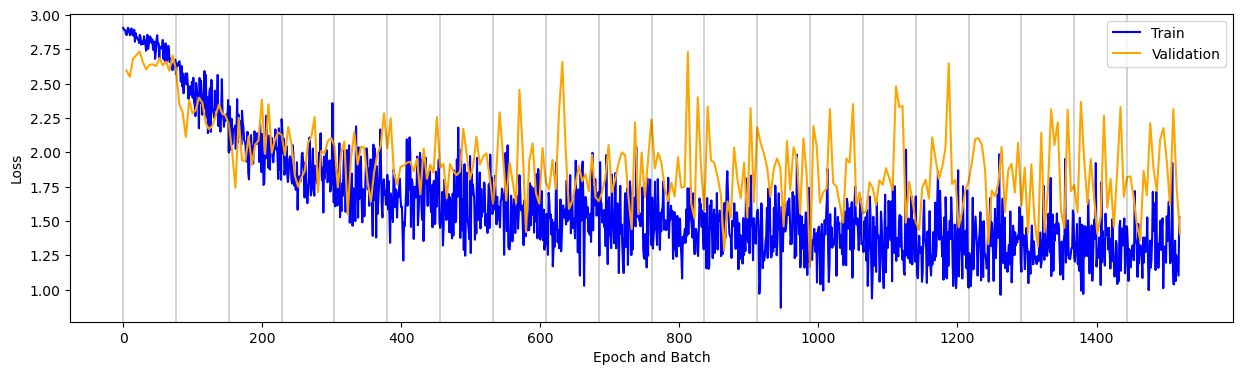

In [20]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue')
plt.plot(val_ticks, losses['val'], c='orange')
for i in range(args.num_epochs):
    plt.axvline(x=i*len(losses['train'])/args.num_epochs, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [21]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [22]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.8160582482814789;
Test Accuracy: 44.75


### Inference

In [23]:
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).view(1, -1)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}


In [24]:
new_surname = input("Enter a surname to classify: ")
classifier = classifier.to("cpu")
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

Geinitz -> Spanish (p=0.40)


In [25]:
vectorizer.vectorize('Geinitz')

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [26]:
torch.tensor(vectorizer.vectorize('geinitz')).view(1,-1).shape

torch.Size([1, 77])

### Top-K Inference

In [27]:
def predict_topk_nationality(name, classifier, vectorizer, k=18):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]
    
    results = []
    for prob_value, index in zip(probability_values, indices):
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        results.append({'nationality': nationality, 
                        'probability': prob_value})
    
    return results


new_surname = input("Enter a surname to classify: ")
classifier = classifier.to("cpu")

k = int(input("How many of the top predictions to see? "))
if k > len(vectorizer.nationality_vocab):
    print("Sorry! That's more than the # of nationalities we have.. defaulting you to max size :)")
    k = len(vectorizer.nationality_vocab)
    
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))

Top 10 predictions:
Geinitz -> Spanish (p=0.40)
Geinitz -> German (p=0.24)
Geinitz -> Polish (p=0.10)
Geinitz -> Scottish (p=0.08)
Geinitz -> Russian (p=0.05)
Geinitz -> Italian (p=0.04)
Geinitz -> French (p=0.03)
Geinitz -> English (p=0.02)
Geinitz -> Portuguese (p=0.02)
Geinitz -> Czech (p=0.01)


In [28]:
import torchsummary
torchsummary.summary(classifier, dataset[0]['x_surname'].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]          23,400
            Linear-2                   [-1, 18]           5,418
Total params: 28,818
Trainable params: 28,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
----------------------------------------------------------------
